## <font color="darkblue"> ML models to discriminate between fishing trips from federal verse state waters using catch compositions on U.S. West Coast landing receipts</font>

Version: 2<br>
Date: 01/26/2023<br>
Author: Robert T. Ames

### Study:
This code was used to train and test two machine learning models that could discriminate between fishing trips from federal verse state waters using the catch compositions on the landing records (i.e., fish tickets). The landing records for training and testing the models were linked to observer data to create the labels. The labels are binary, where 1 denotes trips where the vessel fished exclusively in Federal waters, and 0 denotes trips where the vessel fished exclusively in state waters. Trips that included fishing in both federal and state waters were excluded. The landing records were from open access fixed gear fishing vessels where the plurality of the species landed were groundfish and where the landings occurred on the U.S. west coast (northern Washington to southern California) between 2002 and 2019. The delivery ports, dates, and vessel ID information has been withheld and some initial data preprocessing was performed to protect confidentiality. 
The notebook includes:
* Initial data preprocessing steps, which have been comment out to render those code blocks inert. This code was included to show the complete process, but is unnecessary to run the provided code using the data in this repo. The preprocessing steps comprised of (1) pulling data from database, (2) pivoting landings by species or species group, one row per landing record, (3) splitting the data into training (80%) and testing datasets (20%) and stratifying by the label, and (4) normalizing the training data and applying that transformation blindly to the testing data
* Forward stepwise subset selection process on the training data to determine the best variables for the random forest and gradient boosting models. The subset selection process was executed separately for each model and used 10-fold cross-validation. Final selected variables for each model were those that produced the highest mean accuracy with the lowest standard error using the fewest number of variables 
* plot the difference combinations of variables selected during the stepwise process along the model accurancy scoring and standard error for each subset selection
* Variable of importances scoring was performed on the variables chosen by the sequential forward selection process. The second variable selection process was to decrease the complexity of the models by reducing the number of variables and prevent overfitting. The aim was to reduce the selected variables to the most relevant variables for each model, the group of variables that together provided greater than 98% of the overall score for making predictions. The other variables were determine to be irrelevant to the models and were discarded 
* The models were tuned to determine the best hyperparameters using the all the training data, but only the best variables from the stacking of the to subset selection processes. The models were fit to the training data and 10-fold cross-validation with accuracy scoring to evaluate the fits
* The optimal random forest and gradient boosting models with best hyperparameters were refit to all the training data, but only using the subset variables. The models were then fit to the testing data to evaluate the model performances. This last step provided an indication on how the model would perform on out-of-sample data
* To ensure persistence of model efficacy despite such inter-annual variability, the selected subset of variables were also used to fit the models whose training data iterated through all but one year, and were tested on the remaining year


Note: The sequential forward selection process will provide slightly different results each time it is executed. However, the subset selection of the top 5 variables is consistent and will provide about the same level of model fit and performance (i.e., ~97% accuracy on the testing data). 

In [1]:
# Python version used in this study
from platform import python_version
print(python_version())

3.9.12


In [2]:
# Loading packages
import time
#import cx_Oracle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# suppressing warning messages
import warnings
warnings.filterwarnings('ignore')

In [4]:
# timing the durations to run the code
start = time.time()

#### Initial data preprocessing steps:
These steps have been comment out to render those code blocks inert, and are not necessary to execute the below scripts and models. Non-confidential training and testing datasets are provided in this repo, which were used in this study. 

In [5]:
# from getpass import getpass
# password = getpass()

In [6]:
# user = "XXXX"
# host = "pacfin..."
# port = "9999"
# sid = "XXXXX"
# pswd = password
# dsn = cx_Oracle.makedsn (host, port, sid)

# connection  = cx_Oracle.connect (user, pswd, dsn)

In [7]:
# pulling in landings linked to observer trips from master table 
# sql = "SELECT keyid, pacfin_year, species_name, area_code, kg, origin_catch, total_receipt_kg, dist_202m_depth FROM enf.ole_fedwater_viol_manuscript  WHERE pacfin_year > 2001 AND fishery = 'GRND' AND wcgop_trip_id <>  28716 AND pacfin_group_gear_code <> 'TLS' AND wcgop_trip_id IS NOT NULL AND kg > 10"
# wcomp = pd.read_sql(sql, con=connection)
# pd.options.display.max_columns = None

In [8]:
#saving copy of file
# wcomp.to_csv('wcomp.csv')

In [9]:
#wcomp = pd.read_csv('wcomp.csv', index_col=0)

In [10]:
# pivot on species to create a wide dataframe with species separated into columns, and one row per ticket
# wcomp_pivot = wcomp.pivot_table('KG', ['KEYID', 'PACFIN_YEAR', 'AREA_CODE', 'ORIGIN_CATCH', 'DIST_202M_DEPTH', 'TOTAL_DAY_KG', 'TOTAL_RECEIPT_KG'], 'SPECIES_NAME') 
# wcomp_pivot = wcomp_pivot.fillna(0)
# wcomp_pivot = wcomp_pivot.reset_index()

In [11]:
# renaming some variables, the database provide the headers in uppercase
# wcomp_pivot.rename(columns={"AREA_CODE": "Label", "PACFIN_YEAR": "Year", "DIST_202M_DEPTH": "Distance 202m Depth", "TOTAL_DAY_KG": "Total Daily Kg", "TOTAL_RECEIPT_KG": "Total Receipt Kg", "ORIGIN_CATCH": "Origin Catch"}, inplace=True)

In [12]:
# copy of the data for analysis
# wcomp_pivot_ml = wcomp_pivot.copy()

In [13]:
# dropping unnecessary columns
# wcomp_pivot_ml.drop(['KEYID', 'Origin Catch', 'Year'], axis=1, inplace=True)

In [14]:
# pulling out the label from dataframe
# X = wcomp_pivot_ml

# y = X.pop('Label')

In [15]:
# number of rows and columns
# print('X shape:', X.shape)
# print('y shape:', y.shape)

X shape: (10630, 116)
y shape: (10630,)


In [16]:
# train and test splits, test is only 20%, and stratified by area
# from sklearn.model_selection import train_test_split

# x_train_plot, x_test_plot, y_train_plot, y_test_plot = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [17]:
# training_df_plot = pd.concat([x_train_plot, y_train_plot], axis=1)

In [18]:
# training_df_plot.Label.value_counts()

1    4524
0    3980
Name: Label, dtype: int64

In [19]:
#decoding for plot presentations
# Replace = training_df_plot.loc[:, "Label"] == 1
# training_df_plot.loc[Replace, "Label"] = "Federal Waters"

# #decoding for plot presentations
# Replace = training_df_plot.loc[:, "Label"] == 0
# training_df_plot.loc[Replace, "Label"] = "State Waters"

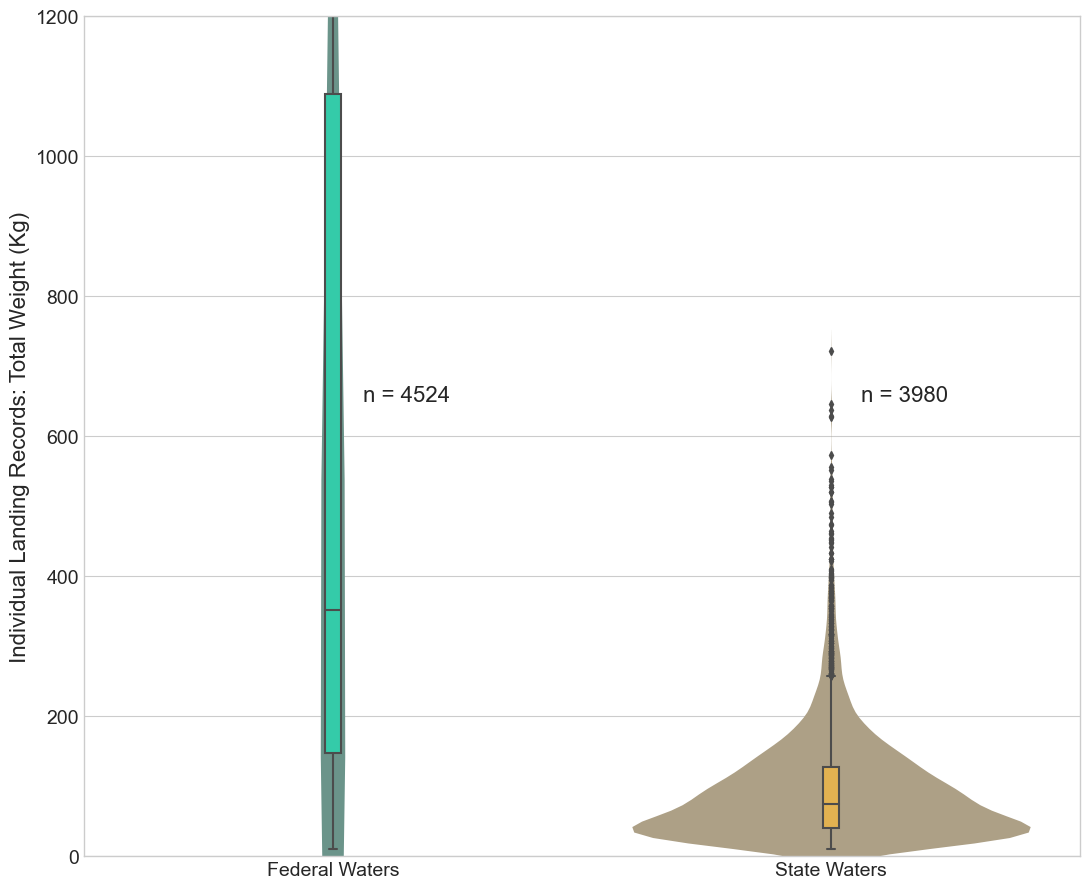

In [20]:
# plt.style.use('seaborn-whitegrid') 
# fig = plt.figure(figsize=(11, 9)).gca()

# flierprops = dict(markersize=4,
#               linestyle='none')

# ax = sns.violinplot(data = training_df_plot, palette='turbo', x = 'Label', y = 'Total Receipt Kg', inner=None, linewidth=0, saturation=0.2)
# sns.boxplot(data = training_df_plot, x='Label', y='Total Receipt Kg', palette='turbo', width=0.032, flierprops=flierprops,
#             boxprops={'zorder': 2}, ax=ax)
# ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.ylim(0,1200)
# plt.text(0.06,650, 'n = 4524', fontsize=16) #4524
# plt.text(1.06,650, 'n = 3980', fontsize=16)
# plt.ylabel("Individual Landing Records: Total Weight (Kg)", fontsize=16)
# plt.xlabel("", fontsize=13) #Origin of Fishing
# plt.tight_layout()
# #plt.savefig('PlotManuscript_violinfnlRA.png', dpi=600)

In [21]:
# importing min/max scaler to normalize all weight columns as well as vessel length
# this is not necessary for decision trees, but b/c these data are going to be provided to GITHUB it's necessary
# for confidentiality
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# # normalizing data
# x_train.loc[:,'Distance 202m Depth':'Yellowtail Rockfish'] = scaler.fit_transform(x_train.loc[:,'Distance 202m Depth':'Yellowtail Rockfish'])


# #Same scale as the training data. 
# x_test.loc[:,'Distance 202m Depth':'Yellowtail Rockfish'] = scaler.transform(x_test.loc[:,'Distance 202m Depth':'Yellowtail Rockfish'])

In [22]:
#saving copy of file
# x_train.to_csv('x_train.csv')
# x_test.to_csv('x_test.csv')
# y_train.to_csv('y_train.csv')
# y_test.to_csv('y_test.csv')

#### End of initial data preprocessing steps:
The above steps have been comment out to render those code blocks inert. The below 4 non-confidential datasets have been provided in this repo. Those dataset have been split into the training and testing. 

In [23]:
# 4 non-confidential datasets
x_train = pd.read_csv('x_train.csv', index_col=0)
x_test = pd.read_csv('x_test.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
y_test = pd.read_csv('y_test.csv', index_col=0)

In [24]:
# merging the datasets to create the violin plot below
training_df = pd.concat([x_train, y_train], axis=1)
testing_df = pd.concat([x_test, y_test], axis=1)

In [25]:
# test data record counts
testing_df.Label.value_counts()

1    1131
0     995
Name: Label, dtype: int64

In [26]:
# training data record counts
training_df.Label.value_counts()

1    4524
0    3980
Name: Label, dtype: int64

In [27]:
# dataframe for below violin plot
training_df.head()

,Distance 202m Depth,Total Daily Kg,Total Receipt Kg,Albacore,Arrowtooth Flounder,Aurora Rockfish,Bank Rockfish,Bat Ray,Big Skate,Black And Yellow Rockfish,...,Unsp. Squid,Vermilion Rockfish,White Seabass,Widow Rockfish,Wolf Eel,Yelloweye Rockfish,Yellowfin Tuna,Yellowtail,Yellowtail Rockfish,Label
8851,0.003198,0.003234,0.004376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
521,0.053466,0.001811,0.002450,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6060,0.029206,0.004243,0.005742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
635,0.053466,0.001162,0.001573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
668,0.051074,0.003243,0.000402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [28]:
#decoding for plot presentations
Replace = training_df.loc[:, "Label"] == 1
training_df.loc[Replace, "Label"] = "Federal Waters"

#decoding for plot presentations
Replace = training_df.loc[:, "Label"] == 0
training_df.loc[Replace, "Label"] = "State Waters"

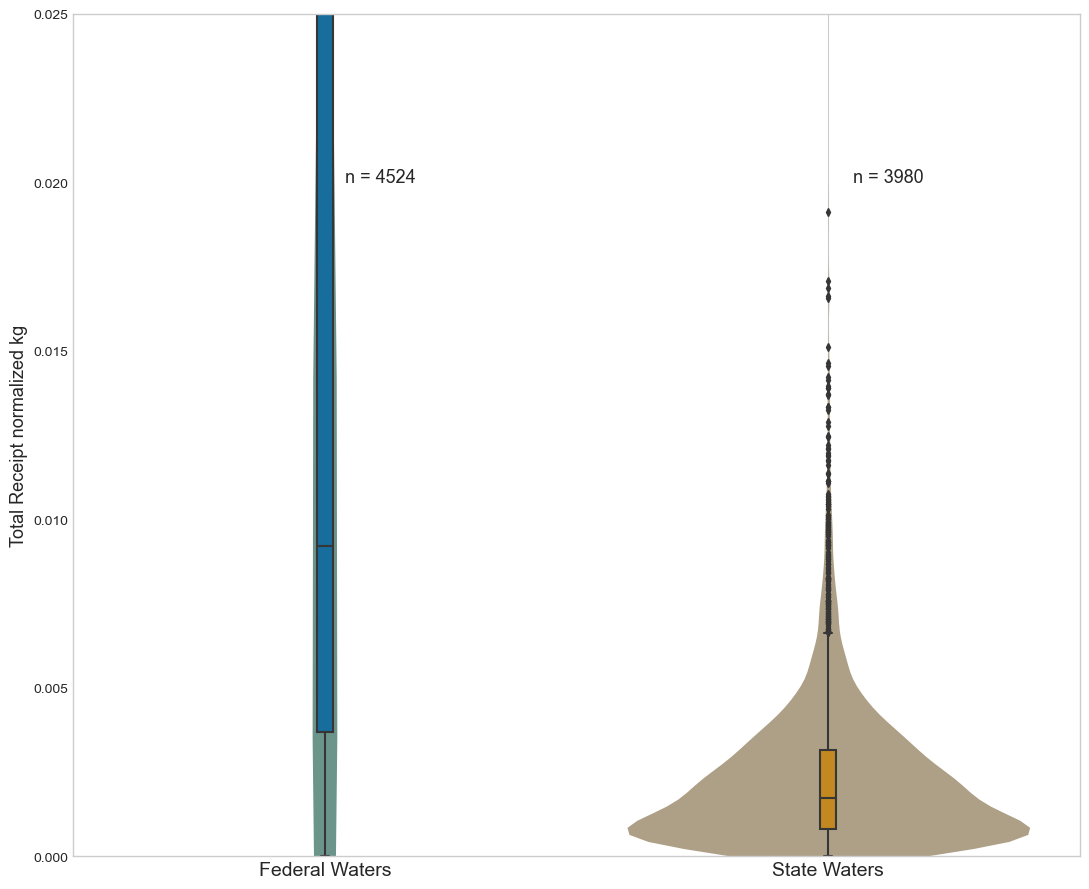

In [29]:
# violin plot of the distribution of total weight landed on landing record by Federal and state waters
plt.style.use('seaborn-whitegrid') 
fig = plt.figure(figsize=(11, 9)).gca()

flierprops = dict(markersize=4,
              linestyle='none')

ax = sns.violinplot(data = training_df, palette='turbo', x = 'Label', y = 'Total Receipt Kg', inner=None, linewidth=0, saturation=0.2)
sns.boxplot(data = training_df, x='Label', y='Total Receipt Kg', palette='colorblind', width=0.032, flierprops=flierprops,
            boxprops={'zorder': 2}, ax=ax)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 14)
#plt.title('Violin Plot of Total Ticket Lbs. by State and Federal Waters \n', fontsize=14)
plt.grid()  
plt.ylim(0,0.025)
plt.text(0.04,0.02, 'n = 4524', fontsize=13)
plt.text(1.05,0.02, 'n = 3980', fontsize=13)
plt.ylabel("Total Receipt normalized kg", fontsize=13)
plt.xlabel("", fontsize=13) #Origin of Fishing
plt.tight_layout()

In [30]:
# loading feature selection package
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

print('Training dataset shape:', x_train.shape, y_train.shape)
print('Testing dataset shape:', x_test.shape, y_test.shape)

Training dataset shape: (8504, 116) (8504, 1)
Testing dataset shape: (2126, 116) (2126, 1)


In [31]:
# stratified split for training
y_train.value_counts(normalize=True)

Label
1        0.531985
0        0.468015
dtype: float64

In [32]:
# stratified split for testing
y_test.value_counts(normalize=True)

Label
1        0.531985
0        0.468015
dtype: float64

### Random Forest Classification 

In [33]:
# The random forest classifier
from sklearn.ensemble import RandomForestClassifier 

# Build RF classifier to use in feature selection
clf = RandomForestClassifier() 

# Build step forward feature selection using 10-fold cross-validation and accuracy scoring
sfs1 = sfs(estimator=clf, 
           k_features=(1, 116), 
           forward=True, 
           n_jobs=-1,
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=10)

# Perform SFFS
sfs1 = sfs1.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:  1.3min finished

[2023-02-04 11:21:58] Features: 1/116 -- score: 0.8926389714522708[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:  2.1min finished

[2023-02-04 11:24:01] Features: 2/116 -- score: 0.9557840602751089[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:  1.7min finished

[2023-02-04 11:25:42] Features: 3/116 -- score: 0.9637799129052326[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 113 ou

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:  2.0min finished

[2023-02-04 12:29:35] Features: 31/116 -- score: 0.9774217183935855[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:  2.0min finished

[2023-02-04 12:31:36] Features: 32/116 -- score: 0.9775389507154214[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:  1.9min finished

[2023-02-04 12:33:33] Features: 33/116 -- score: 0.9778918918918919[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:  1.9min finished

[2023-02-04 12:35:30] Features: 34/

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:  1.5min finished

[2023-02-04 13:23:36] Features: 61/116 -- score: 0.9782446948226999[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  1.5min finished

[2023-02-04 13:25:04] Features: 62/116 -- score: 0.9785970830165203[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  1.4min finished

[2023-02-04 13:26:31] Features: 63/116 -- score: 0.9784792977120343[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:  1.7min finished

[2023-02-04 13:28:14] Features: 64/

[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   41.7s finished

[2023-02-04 14:01:25] Features: 95/116 -- score: 0.9784792977120343[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   41.3s finished

[2023-02-04 14:02:06] Features: 96/116 -- score: 0.9781269095182139[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   35.1s finished

[2023-02-04 14:02:41] Features: 97/116 -- score: 0.9783617888988733[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   34.9s finished

[2023-02-04 14:03:17] Features: 98/116 -- score: 0.9783619271445358[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   34.9s finished

[2023-02-04 14:03:52] Features: 99/116 -- score: 0.9778913389092416[

In [34]:
sfs_rf_df = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T.sort_index(ascending=True)

In [35]:
# best model accuracy score included these variables (the number is the index, e.g., 69 is sablefish)
# However, not all of these variables were used b/c the model overfit
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 22, 26, 27, 30, 32, 33, 35, 36, 37, 38, 40, 41, 42, 43, 44, 47, 49, 50, 52, 54, 57, 60, 61, 63, 65, 66, 67, 69, 70, 71, 72, 73, 74, 76, 82, 83, 84, 90, 91, 94, 98, 99, 101, 102, 103, 107, 108, 109, 111, 115]


In [36]:
# creating a dataframe to process the forward selection results
sfs_rf_df_maxmin = sfs_rf_df.loc[: ,['feature_idx', 'avg_score', 'std_err']]

In [37]:
sfs_rf_df_maxmin['idx_len'] = sfs_rf_df_maxmin['feature_idx'].str.len()
sfs_rf_df_maxmin['avg_score_rank'] = sfs_rf_df_maxmin['avg_score'].rank(ascending = 1)
sfs_rf_df_maxmin['std_err_rank'] = sfs_rf_df_maxmin['std_err'].rank(ascending = 1)

In [38]:
# final selected variables for each model were those that produced the highest mean accuracy 
# with the lowest standard error using the fewest number of variables
sfs_rf_df_maxmin['total_score'] = sfs_rf_df_maxmin['std_err_rank'] + sfs_rf_df_maxmin['avg_score_rank'] + sfs_rf_df_maxmin['idx_len']

In [39]:
sfs_rf_df_opt = sfs_rf_df_maxmin[sfs_rf_df_maxmin.total_score == sfs_rf_df_maxmin.total_score.min()]

x_train_rf = x_train.iloc[:,list(tuple(list(sfs_rf_df_opt["feature_idx"])[0]))]

Text(0, 0.5, 'Std Error')

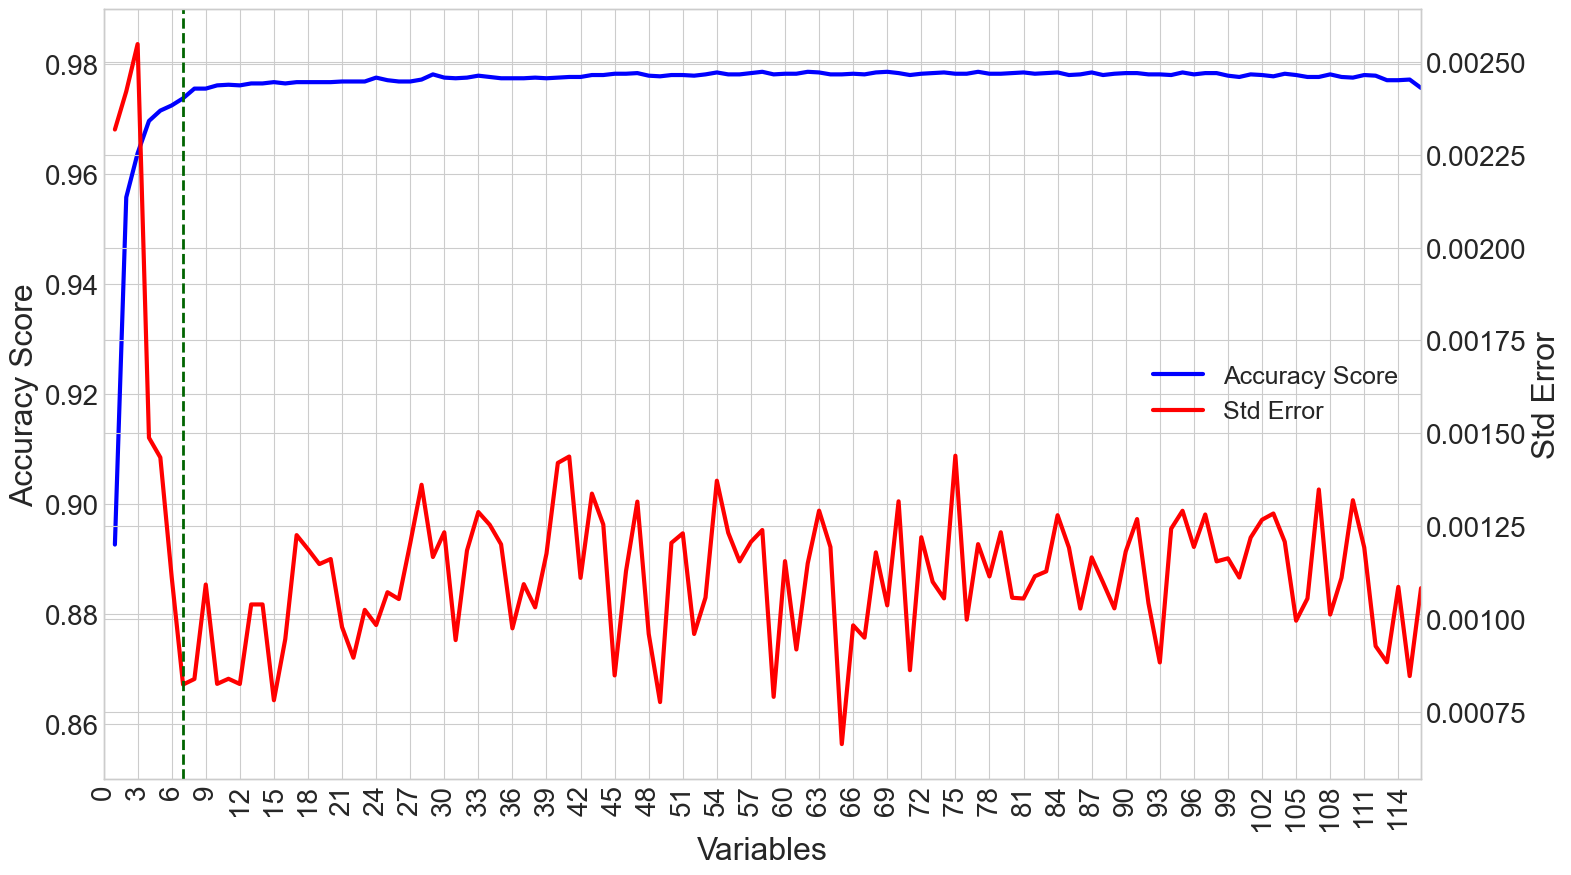

In [40]:
# Plot of the sequential forward selection process for the random forest.
# The optimal model fit is shown by the vertical dotted lines

plt.style.use('seaborn-whitegrid')
y1 = sfs_rf_df.loc[:,'avg_score']
y2 = sfs_rf_df.loc[:,'std_err']
x = range(1,117, 1) 


fig, ax1 = plt.subplots(figsize=(17, 10))

plt.ylim([0.85, 0.99])
plt.yticks(fontsize=20)
plt.xticks(np.arange(0, 117, step=3), rotation='vertical', fontsize=20)
plt.xlim([0, 116])

#plt.title('Random Forest', fontsize=22)
ax2 = ax1.twinx()
plt.yticks(fontsize=20)
line1, = ax1.plot(x, y1, 'b-', linewidth=3, label='Accuracy Score')
line2, = ax2.plot(x, y2, 'r-', linewidth=3, label='Std Error')
plt.axvline(list(sfs_rf_df_opt["idx_len"]), color = 'darkgreen', linestyle='dashed', linewidth=2)

ax2.legend(handles=[line1, line2], loc='right', fontsize=18)

ax1.set_xlabel('Variables', fontsize=23)
ax1.set_ylabel('Accuracy Score', fontsize=23)
ax2.set_ylabel('Std Error', fontsize=23)

#plt.savefig('RandomForestForwardSelectionFNLRA.png', dpi=600)


In [41]:
#saving copy of file
#sfs_rf_df_maxmin.to_csv('sfs_rf_df_maxminRA.csv')

In [42]:
# sequential forward selection output for the random forest model
sfs_rf_df_maxmin.head(20)

,feature_idx,avg_score,std_err,idx_len,avg_score_rank,std_err_rank,total_score
1,"(69,)",0.892639,0.002318,1,1.0,114.0,116.0
2,"(0, 69)",0.955784,0.002421,2,2.0,115.0,119.0
3,"(0, 1, 69)",0.96378,0.002549,3,3.0,116.0,122.0
4,"(0, 1, 69, 74)",0.96966,0.001488,4,4.0,113.0,121.0
5,"(0, 1, 41, 69, 74)",0.971542,0.001435,5,5.0,110.0,120.0
6,"(0, 1, 10, 41, 69, 74)",0.972483,0.001113,6,6.0,54.0,66.0
7,"(0, 1, 10, 17, 41, 69, 74)",0.973777,0.000823,7,7.0,5.0,19.0
8,"(0, 1, 10, 11, 17, 41, 69, 74)",0.975541,0.000838,8,8.5,8.0,24.5
9,"(0, 1, 10, 11, 17, 41, 69, 74, 108)",0.975541,0.001092,9,8.5,47.0,64.5
10,"(0, 1, 10, 11, 17, 41, 69, 74, 108, 109)",0.976128,0.000825,10,11.0,7.0,28.0


In [43]:
#fit model to training data
clf.fit(x_train_rf, y_train)

RandomForestClassifier()

<Figure size 800x550 with 0 Axes>

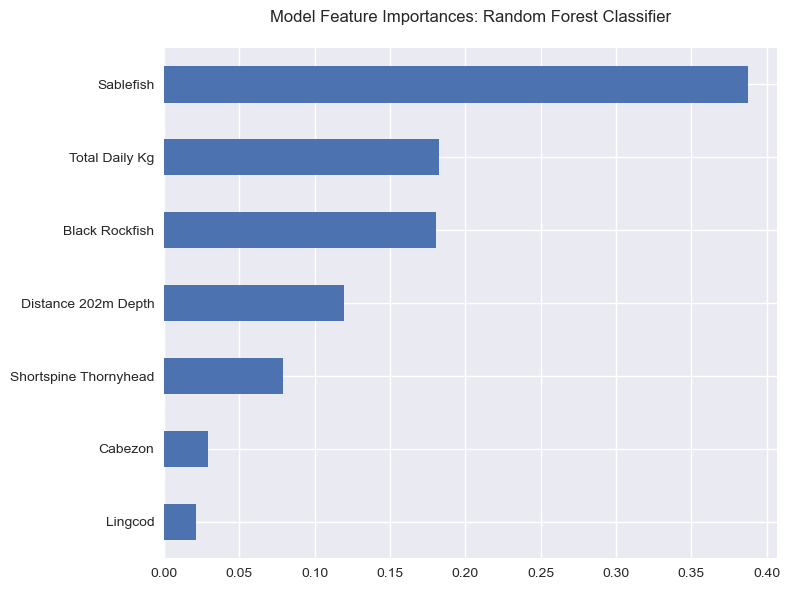

In [44]:
# Variable importance plots for the random forest

plt.style.use('seaborn')
plt.figure()
fig = plt.figure(figsize=(12,16)) # define plot area
ax = fig.gca() # define axis
#ax.set_xlim([0,1.0])
plt.title('Model Feature Importances: Random Forest Classifier\n', fontsize=12)
feature_importances = pd.Series(clf.feature_importances_, index=x_train_rf.columns)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind="barh", figsize=(8,6))
plt.tight_layout()

In [45]:
# Creating a dataframe of the variable importance output from the random forest.
rf_feat_import_df = pd.DataFrame(feature_importances.sort_values(ascending=False))
rf_feat_import_df = rf_feat_import_df.reset_index()
rf_feat_import_df.columns = ['Variable', 'Importance_value']

In [46]:
#saving copy of file
#rf_feat_import_df.to_csv('rf_feat_import_dfRA.csv')

In [47]:
rf_feat_import_df

,Variable,Importance_value
0,Sablefish,0.387732
1,Total Daily Kg,0.182826
2,Black Rockfish,0.180296
3,Distance 202m Depth,0.119692
4,Shortspine Thornyhead,0.079255
5,Cabezon,0.028866
6,Lingcod,0.021333


In [48]:
# Selecting the top variables that contribute to >98% of importance score
def important_variables(numbers):
    total = 0
    for number in numbers:
        if total > 0.98:
            break
        total += number
    return number

In [49]:
# top x_train_top_variables that are important, which are used in a grid search for best hyperparameters
x_train_top_variables = rf_feat_import_df.loc[rf_feat_import_df['Importance_value'] > important_variables(rf_feat_import_df.iloc[:,1]), ['Variable','Importance_value']]

In [50]:
#saving copy of file
#x_train_top_variables.to_csv('x_train_top_variablesRA.csv')

In [51]:
# the final list of most relevent variables
x_train_top_variables

,Variable,Importance_value
0,Sablefish,0.387732
1,Total Daily Kg,0.182826
2,Black Rockfish,0.180296
3,Distance 202m Depth,0.119692
4,Shortspine Thornyhead,0.079255
5,Cabezon,0.028866


In [52]:
# most relevent variables are used in a grid search for best hyperparameters
x_train_rf_grid = x_train.loc[:,list(x_train_top_variables.iloc[:,0])]

In [53]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = list(range(63, 1000, 20)) #[int(x) for x in np.linspace(start = 100, stop = 1500, num = 35)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
criterion = ['gini', 'entropy']
# Maximum number of levels in tree
# Change to reduce overfiting 
max_depth = [int(x) for x in np.linspace(1, 40, num = 15)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [3, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 6]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'criterion': criterion,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [63, 83, 103, 123, 143, 163, 183, 203, 223, 243, 263, 283, 303, 323, 343, 363, 383, 403, 423, 443, 463, 483, 503, 523, 543, 563, 583, 603, 623, 643, 663, 683, 703, 723, 743, 763, 783, 803, 823, 843, 863, 883, 903, 923, 943, 963, 983], 'max_features': ['auto', 'sqrt'], 'criterion': ['gini', 'entropy'], 'max_depth': [1, 3, 6, 9, 12, 14, 17, 20, 23, 26, 28, 31, 34, 37, 40], 'min_samples_split': [3, 5, 10, 15, 20], 'min_samples_leaf': [1, 2, 3, 4, 6], 'bootstrap': [True, False]}


In [54]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier() #RandomForestRegressor()
# Random search of parameters, using 10 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 10, verbose=2, random_state=42, n_jobs = -1, scoring='accuracy')
# Fit the random search model
rf_random.fit(x_train_rf_grid, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 3, 6, 9, 12, 14, 17,
                                                      20, 23, 26, 28, 31, 34,
                                                      37, 40],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4, 6],
                                        'min_samples_split': [3, 5, 10, 15, 20],
                                        'n_estimators': [63, 83, 103, 123, 143,
                                                         163, 183, 203, 223,
                                                         243, 263, 283, 303,
                                                         323, 343, 363, 383,
                                                         403, 423, 443, 463,
                                                         483, 503, 523, 543,
                                                         563, 583, 603, 623,
                                                         643, ...]},
                   random_state=42, scoring='accuracy', verbose=2)

In [55]:
# new model using the best parameters from gridsearch
rf_best_model = RandomForestClassifier(**rf_random.best_params_)

In [56]:
#fit model with best para and top variables to the training data
rf_best_model.fit(x_train_rf_grid, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=31,
                       min_samples_leaf=6, min_samples_split=5,
                       n_estimators=163)

In [57]:
# modify test data to only include top variables 
x_test_rf_grid = x_test.loc[:,list(x_train_top_variables.iloc[:,0])]

In [58]:
# model prediction on test data
y_pred_rf = rf_best_model.predict(x_test_rf_grid)

probas_rf = rf_best_model.predict_proba(x_test_rf_grid)

In [59]:
from sklearn.metrics import *
from sklearn.metrics import confusion_matrix

print ("\033[1m\nRandom Forest Classifier Performance Matrix:")
pd.DataFrame(
    confusion_matrix(y_test, y_pred_rf, labels=[1,0]),
    columns=['Predicted True', 'Predicted False'],
    index=['Actual True', 'Actual False']
)


Random Forest Classifier Performance Matrix:


,Predicted True,Predicted False
Actual True,1101,30
Actual False,36,959


In [60]:
# ROC analysis
LW_r = 1.5 # line width for plots
LL_r = "lower right" # legend location
LC_r = 'darkgreen' # Line Color

fpr_r, tpr_r, th_r = roc_curve(y_test, probas_rf[:,1]) # False Positive Rate, True Posisive Rate, probability thresholds
AUC = auc(fpr_r, tpr_r)

<Figure size 800x550 with 0 Axes>

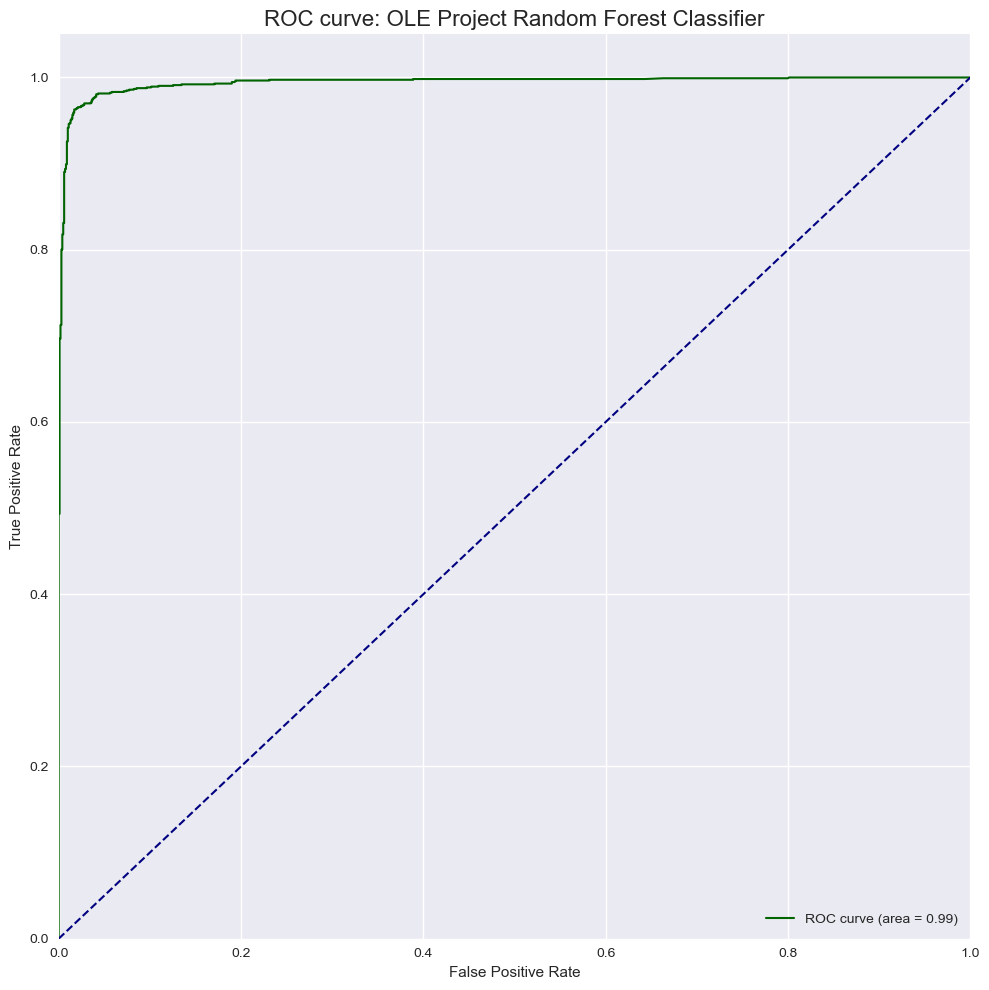

In [61]:
# plotting the ROC curve 
%matplotlib inline

plt.style.use('seaborn')
plt.figure()
fig = plt.figure(figsize=(10,10)) # define plot area
ax = fig.gca() # define axis
plt.title('ROC curve: OLE Project Random Forest Classifier', fontsize=16)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr_r, tpr_r, color=LC_r,lw=LW_r, label='ROC curve (area = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='navy', lw=LW_r, linestyle='--') # reference line for random classifier
plt.legend(loc=LL_r)
plt.tight_layout()
#plt.savefig('RandomForest_ROC_CurveFNLRA.png', dpi=800)

In [62]:
print('Performance Matrix for Random Forest Model')

AR = accuracy_score(y_test, y_pred_rf)
print ("\nRandom Forest Classifier Accuracy rate:", np.round(AR, 3))
ER = 1.0 - AR
print ("\nRandom Forest Classifier Error rate:", np.round(ER, 3))
P = precision_score(y_test, y_pred_rf)
print ("\nRandom Forest Classifier Precision:", np.round(P, 3))
R = recall_score(y_test, y_pred_rf)
print ("\nRandom Forest Classifier Recall:", np.round(R, 3))
F1 = f1_score(y_test, y_pred_rf)
print ("\nRandom Forest Classifier F1 score:", np.round(F1, 3))

Performance Matrix for Random Forest Model

Random Forest Classifier Accuracy rate: 0.969

Random Forest Classifier Error rate: 0.031

Random Forest Classifier Precision: 0.968

Random Forest Classifier Recall: 0.973

Random Forest Classifier F1 score: 0.971


### Gradient Boosting Classifier 

In [63]:
# The gradient boosting classifier 
from sklearn.ensemble import GradientBoostingClassifier

# Build RF classifier to use in feature selection
gbc = GradientBoostingClassifier()

# Build step forward feature selection
sfs2 = sfs(estimator=gbc, 
           k_features=(1, 116), 
           forward=True, 
           n_jobs=-1,
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=10)

# Perform SFS
sfs2 = sfs2.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 116 out of 116 | elapsed:   36.3s finished

[2023-02-04 14:21:23] Features: 1/116 -- score: 0.8979303241860785[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 115 out of 115 | elapsed:  1.3min finished

[2023-02-04 14:22:43] Features: 2/116 -- score: 0.9573129190571645[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 114 out of 114 | elapsed:  1.6min finished

[2023-02-04 14:24:19] Features: 3/116 -- score: 0.9680149305315545[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 113 ou

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  86 out of  86 | elapsed:  3.0min finished

[2023-02-04 15:47:02] Features: 31/116 -- score: 0.9756578419852078[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  85 out of  85 | elapsed:  3.1min finished

[2023-02-04 15:50:09] Features: 32/116 -- score: 0.9756578419852078[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:  3.0min finished

[2023-02-04 15:53:10] Features: 33/116 -- score: 0.9756578419852078[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  83 out of  83 | elapsed:  3.1min finished

[2023-02-04 15:56:13] Features: 34/

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:  2.7min finished

[2023-02-04 17:18:08] Features: 61/116 -- score: 0.9756578419852078[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:  2.8min finished

[2023-02-04 17:20:58] Features: 62/116 -- score: 0.9756578419852078[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  2.8min finished

[2023-02-04 17:23:47] Features: 63/116 -- score: 0.9756578419852078[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:  3.1min finished

[2023-02-04 17:26:53] Features: 64/

[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:  1.6min finished

[2023-02-04 18:37:47] Features: 95/116 -- score: 0.9757756272896938[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  1.8min finished

[2023-02-04 18:39:37] Features: 96/116 -- score: 0.9761281537291768[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.5min finished

[2023-02-04 18:41:09] Features: 97/116 -- score: 0.9758928596115297[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:  1.5min finished

[2023-02-04 18:42:39] Features: 98/116 -- score: 0.9756575654938826[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  1.4min finished

[2023-02-04 18:44:05] Features: 99/116 -- score: 0.9750701596737403[

In [64]:
sfs_gb_df = pd.DataFrame.from_dict(sfs2.get_metric_dict()).T.sort_index(ascending=True)

In [65]:
# best model accuracy score included these variables (the number is the index, e.g., 69 is sablefish)
# However, not all of these variables were used b/c the model overfit
gb_feat_cols = list(sfs2.k_feature_idx_)
print(gb_feat_cols)

[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 21, 22, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 91, 92, 93, 95, 96, 97, 98, 100, 103, 104, 105, 106, 107, 109, 111, 112, 113, 114]


In [66]:
# creating a dataframe to process the forward selection results
sfs_gb_df_maxmin = sfs_gb_df.loc[: ,['feature_idx', 'avg_score', 'std_err']]

In [67]:
sfs_gb_df_maxmin['idx_len'] = sfs_gb_df_maxmin['feature_idx'].str.len()
sfs_gb_df_maxmin['avg_score_rank'] = sfs_gb_df_maxmin['avg_score'].rank(ascending = 1)
sfs_gb_df_maxmin['std_err_rank'] = sfs_gb_df_maxmin['std_err'].rank(ascending = 1)

In [68]:
# final selected variables for each model were those that produced the highest mean accuracy 
# with the lowest standard error using the fewest number of variables
sfs_gb_df_maxmin['total_score'] = sfs_gb_df_maxmin['std_err_rank'] + sfs_gb_df_maxmin['avg_score_rank'] + sfs_gb_df_maxmin['idx_len']

In [69]:
sfs_gb_df_opt = sfs_gb_df_maxmin[sfs_gb_df_maxmin.total_score == sfs_gb_df_maxmin.total_score.min()]

x_train_gb = x_train.iloc[:,list(tuple(list(sfs_gb_df_opt["feature_idx"])[0]))]

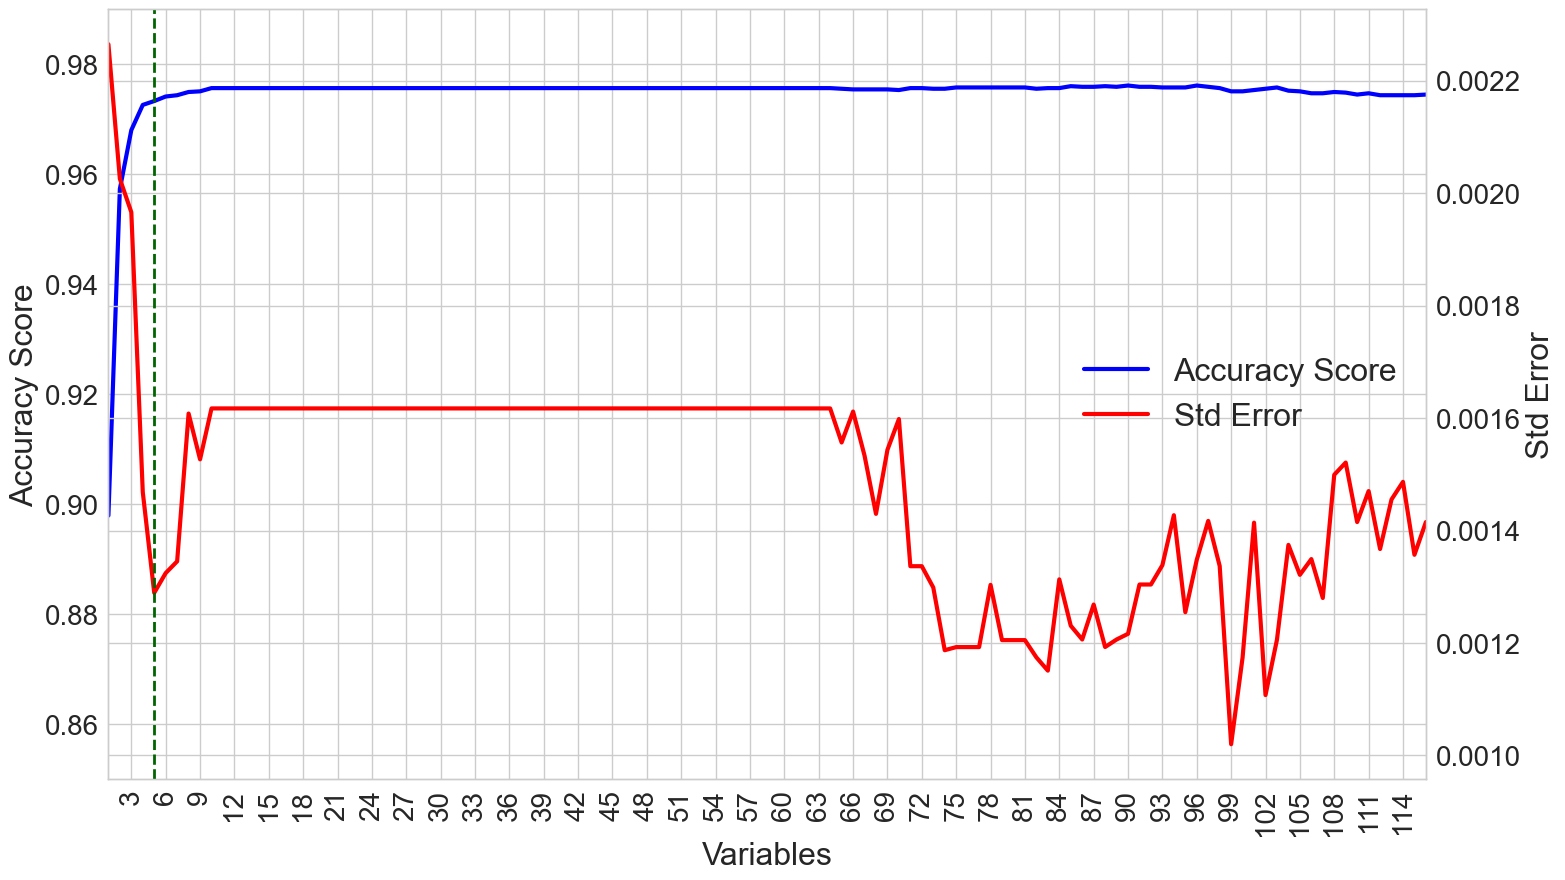

In [70]:
# Plot of the sequential forward selection process for the gradient boosting model.
# The optimal model fit is shown by the vertical dotted lines

plt.style.use('seaborn-whitegrid')
y1 = sfs_gb_df.loc[:,'avg_score']
y2 = sfs_gb_df.loc[:,'std_err']
x = range(1,117, 1) 

fig, ax1 = plt.subplots(figsize=(17, 10))

plt.ylim([0.85, 0.99])
plt.yticks(fontsize=20)
plt.xticks(np.arange(0, 118, step=3), rotation='vertical', fontsize=20)
plt.xlim([1, 116])

#plt.title('Gradient Boosting', fontsize=22)
ax2 = ax1.twinx()
plt.yticks(fontsize=20)
line1, = ax1.plot(x, y1, 'b-', linewidth=3, label='Accuracy Score')
line2, = ax2.plot(x, y2, 'r-', linewidth=3, label='Std Error')
plt.axvline(list(sfs_gb_df_opt["idx_len"]), color = 'darkgreen', linestyle='dashed', linewidth=2)

ax2.legend(handles=[line1, line2], loc='right', fontsize=23)

ax1.set_xlabel('Variables', fontsize=23)
ax1.set_ylabel('Accuracy Score', fontsize=23)
ax2.set_ylabel('Std Error', fontsize=23)

#plt.savefig('GradientboostingForwardSelectionFNLRA.png', dpi=600)
plt.show()

In [71]:
#saving copy of file
#sfs_gb_df_maxmin.to_csv('sfs_gb_df_maxminRA.csv')

In [72]:
sfs_gb_df_maxmin.head(20)

,feature_idx,avg_score,std_err,idx_len,avg_score_rank,std_err_rank,total_score
1,"(69,)",0.89793,0.002265,1,1.0,116.0,118.0
2,"(0, 69)",0.957313,0.002026,2,2.0,115.0,119.0
3,"(0, 1, 69)",0.968015,0.001966,3,3.0,114.0,120.0
4,"(0, 1, 69, 74)",0.9726,0.001468,4,4.0,47.0,55.0
5,"(0, 1, 10, 69, 74)",0.973306,0.001289,5,5.0,22.0,32.0
6,"(0, 1, 10, 63, 69, 74)",0.974129,0.001324,6,6.0,29.0,41.0
7,"(0, 1, 10, 11, 63, 69, 74)",0.974364,0.001345,7,9.5,34.0,50.5
8,"(0, 1, 10, 11, 19, 63, 69, 74)",0.974952,0.001608,8,18.0,57.0,83.0
9,"(0, 1, 10, 11, 19, 63, 67, 69, 74)",0.97507,0.001527,9,21.0,52.0,82.0
10,"(0, 1, 10, 11, 19, 63, 67, 69, 74, 104)",0.975658,0.001617,10,65.0,86.0,161.0


In [73]:
#fit model to training data
gbc.fit(x_train_gb, y_train)

GradientBoostingClassifier()

<Figure size 800x550 with 0 Axes>

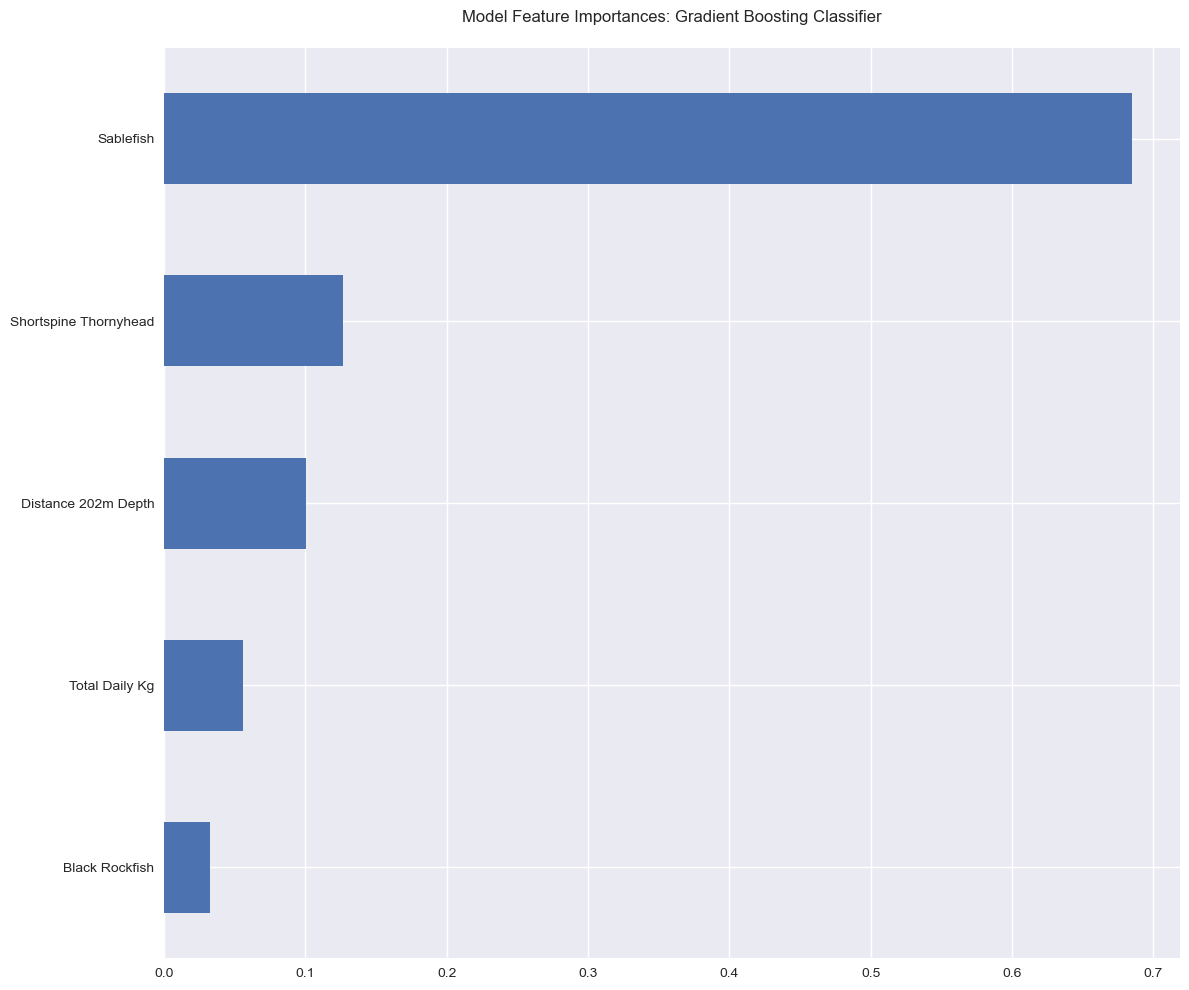

In [74]:
plt.style.use('seaborn')
plt.figure()
fig = plt.figure(figsize=(12,16)) # define plot area
ax = fig.gca() # define axis
#ax.set_xlim([0,1.0])
plt.title('Model Feature Importances: Gradient Boosting Classifier\n', fontsize=12)
feature_importances_gb = pd.Series(gbc.feature_importances_, index=x_train_gb.columns)
feature_importances_gb.sort_values(inplace=True)
feature_importances_gb.plot(kind="barh", figsize=(12,10))
plt.tight_layout()

In [75]:
# creating a dataframe of the variables and their importance value
feat_import_df_gb = pd.DataFrame(feature_importances_gb.sort_values(ascending=False))
feat_import_df_gb = feat_import_df_gb.reset_index()
feat_import_df_gb.columns = ['Variable', 'Importance_value']

In [76]:
# Selecting the top variables that contribute to >98% of importance score
def important_variables(numbers):
    total = 0
    for number in numbers:
        if total > 0.98:
            break
        total += number
    return number

In [77]:
# selecting the top variables only
x_train_top_variables_gb = feat_import_df_gb.loc[feat_import_df_gb['Importance_value'] >= important_variables(feat_import_df_gb.iloc[:,1]), ['Variable','Importance_value']]

In [78]:
#saving copy of file
#x_train_top_variables_gb.to_csv('x_train_top_variables_gbRA.csv')

In [79]:
# top variables that contributed to 98% or more of the importance score
x_train_top_variables_gb

,Variable,Importance_value
0,Sablefish,0.684606
1,Shortspine Thornyhead,0.126712
2,Distance 202m Depth,0.100655
3,Total Daily Kg,0.055493
4,Black Rockfish,0.032534


In [80]:
# top variables that are important, which are used in a grid search for best hyperparameters
x_train_gb_grid = x_train.loc[:,list(x_train_top_variables_gb.iloc[:,0])]

In [81]:
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt 
from sklearn.model_selection import RandomizedSearchCV

gbm_clf = GradientBoostingClassifier()

parameters = {'learning_rate': sp_randFloat(),
              'subsample'    : sp_randFloat(),
              'max_depth'    : sp_randInt(2, 10),
              'n_estimators' : sp_randInt(50, 1000),
              'min_samples_split' : sp_randInt(2, 100),
              'min_samples_leaf'  : sp_randInt(1, 10),
             }



In [82]:
gb_randm = RandomizedSearchCV(estimator=gbm_clf, param_distributions = parameters, 
                           cv = 10, n_iter = 100, n_jobs=-1, scoring='accuracy')
gb_randm.fit(x_train_gb_grid, y_train)

RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000196837C32E0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019683835F10>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructur...ete_frozen object at 0x0000019685A29160>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019683648820>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019685A241F0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000019685A240D0>},
                   scoring='accuracy')

In [83]:
# new model using the best parameters from gridsearch
gb_best_model = GradientBoostingClassifier(**gb_randm.best_params_)

In [84]:
#fit model with best para and top variables to the training data
gb_best_model.fit(x_train_gb_grid, y_train)

GradientBoostingClassifier(learning_rate=0.007966977595900926, max_depth=4,
                           min_samples_leaf=4, min_samples_split=93,
                           n_estimators=951, subsample=0.5523841440289768)

In [85]:
# modify test data to only include top variables 
x_test_gb_grid = x_test.loc[:,list(x_train_top_variables_gb.iloc[:,0])]

In [86]:
# model prediction on test data
y_pred_gb = gb_best_model.predict(x_test_gb_grid)

probas_gb = gb_best_model.predict_proba(x_test_gb_grid)

In [87]:
from sklearn.metrics import *
from sklearn.metrics import confusion_matrix

print ("\033[1m\nRandom Forest Classifier Performance Matrix:")
pd.DataFrame(
    confusion_matrix(y_test, y_pred_gb, labels=[1,0]),
    columns=['Predicted True', 'Predicted False'],
    index=['Actual True', 'Actual False']
)


Random Forest Classifier Performance Matrix:


,Predicted True,Predicted False
Actual True,1100,31
Actual False,31,964


In [88]:
# ROC analysis
LW_r = 1.5 # line width for plots
LL_r = "lower right" # legend location
LC_r = 'darkgreen' # Line Color

fpr_r, tpr_r, th_r = roc_curve(y_test, probas_gb[:,1]) # False Positive Rate, True Posisive Rate, probability thresholds
AUC = auc(fpr_r, tpr_r)

<Figure size 800x550 with 0 Axes>

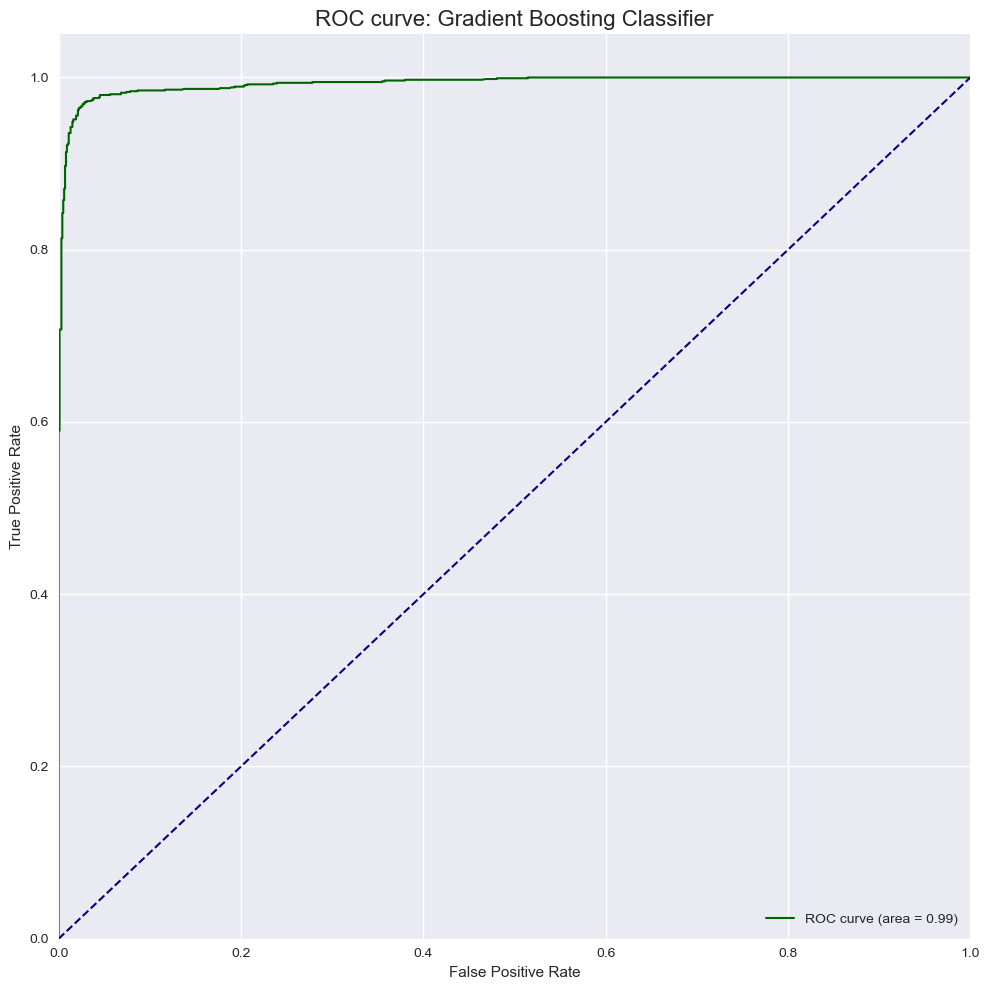

In [89]:
# plotting the ROC curve 
%matplotlib inline

plt.style.use('seaborn')
plt.figure()
fig = plt.figure(figsize=(10,10)) # define plot area
ax = fig.gca() # define axis
plt.title('ROC curve: Gradient Boosting Classifier', fontsize=16)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr_r, tpr_r, color=LC_r,lw=LW_r, label='ROC curve (area = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='navy', lw=LW_r, linestyle='--') # reference line for random classifier
plt.legend(loc=LL_r)
#plt.savefig('GradientBoosting_ROC_CurveFNLRA.png', dpi=800)
plt.tight_layout()

In [90]:
print('Performance Matrix for Gradient Boosting Model')

AR = accuracy_score(y_test, y_pred_gb)
print ("\nRandom Gradient Boosting Accuracy rate:", np.round(AR, 3))
ER = 1.0 - AR
print ("\nRandom Gradient Boosting Error rate:", np.round(ER, 3))
P = precision_score(y_test, y_pred_gb)
print ("\nRandom Gradient Boosting Precision:", np.round(P, 3))
R = recall_score(y_test, y_pred_gb)
print ("\nRandom Gradient Boosting Recall:", np.round(R, 3))
F1 = f1_score(y_test, y_pred_gb)
print ("\nRandom Gradient Boosting F1 score:", np.round(F1, 3))

Performance Matrix for Gradient Boosting Model

Random Gradient Boosting Accuracy rate: 0.971

Random Gradient Boosting Error rate: 0.029

Random Gradient Boosting Precision: 0.973

Random Gradient Boosting Recall: 0.973

Random Gradient Boosting F1 score: 0.973


In [91]:
# combined ROC curve plot for the two models. 

LW_r = 1.5 # line width for plots
LL_r = "lower right" # legend location
LC_r = 'darkgreen' # Line Color

fpr_r, tpr_r, th_r = roc_curve(y_test, probas_rf[:,1]) # False Positive Rate, True Posisive Rate, probability thresholds
AUC = auc(fpr_r, tpr_r)


LW_g = 1.5 # line width for plots
LL_g = "lower right" # legend location
LC_g = 'darkblue' # Line Color

fpr_g, tpr_g, th_g = roc_curve(y_test, probas_gb[:,1]) # False Positive Rate, True Posisive Rate, probability thresholds
AUC = auc(fpr_g, tpr_g)

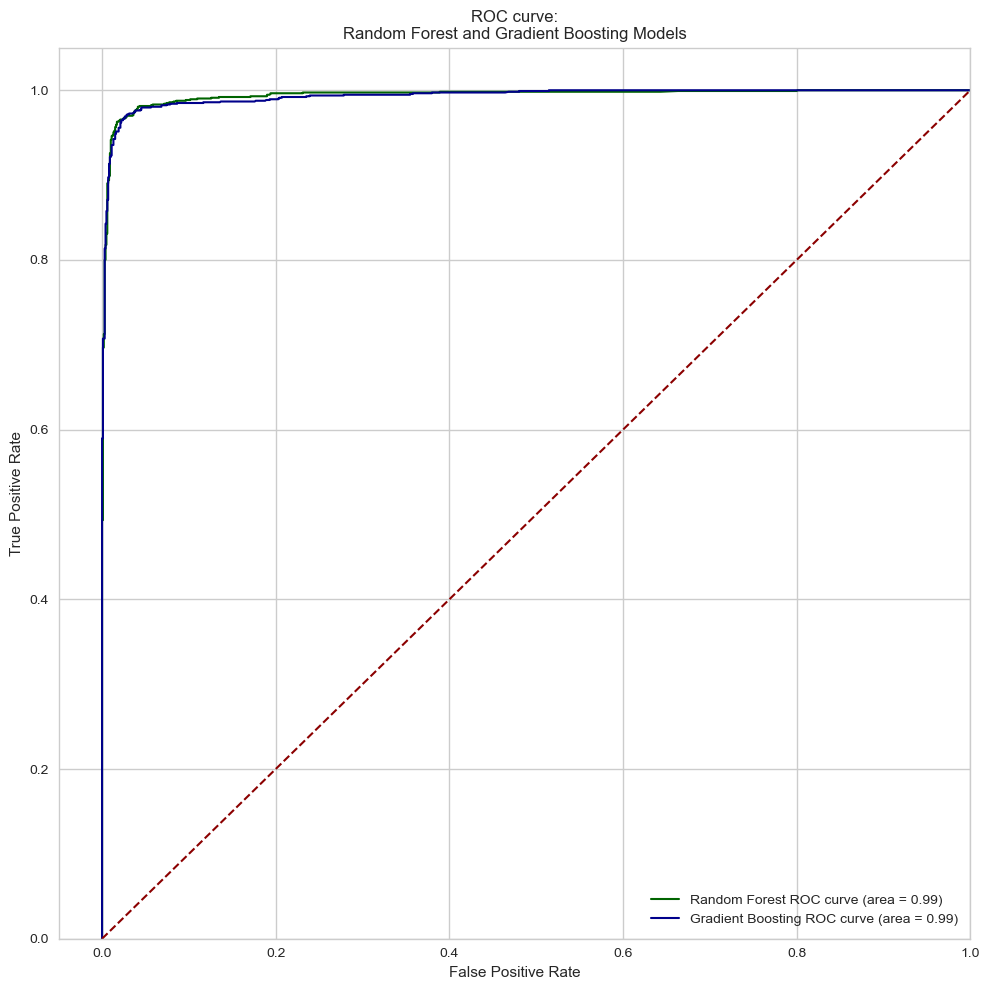

In [92]:
plt.style.use('seaborn-whitegrid') #plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 10)).gca()
plt.title('ROC curve:\nRandom Forest and Gradient Boosting Models', fontsize=12)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr_r, tpr_r, color=LC_r,lw=LW_r, label='Random Forest ROC curve (area = %0.2f)' % AUC)
plt.plot(fpr_g, tpr_g, color=LC_g,lw=LW_g, label='Gradient Boosting ROC curve (area = %0.2f)' % AUC)
plt.plot([0, 1], [0, 1], color='darkred', lw=LW_r, linestyle='--') # reference line for random classifier
plt.legend(loc=LL_r) 
plt.tight_layout()
#plt.savefig('GBandRF_ROC_CurveFNLRA.png', dpi=600)

In [94]:
# combining the variables of importance for the two models
x_train_top_variables_gb.rename(columns={"Importance_value": "GB_Importance_value"}, inplace = True)

In [95]:
x_train_top_variables.rename(columns={"Importance_value": "RF_Importance_value"}, inplace = True)

In [96]:
varimport_df = pd.merge(x_train_top_variables, x_train_top_variables_gb, on='Variable', how='outer') #x_train_top_variables

In [97]:
# These are the combined variables of importanc for the two models
varimport_df

,Variable,RF_Importance_value,GB_Importance_value
0,Sablefish,0.387732,0.684606
1,Total Daily Kg,0.182826,0.055493
2,Black Rockfish,0.180296,0.032534
3,Distance 202m Depth,0.119692,0.100655
4,Shortspine Thornyhead,0.079255,0.126712
5,Cabezon,0.028866,NaN


In [98]:
varimport_df.set_index('Variable', inplace=True) #rf_feat_import_df

In [99]:
# ploting the variables of importance for the two models
font_color = '#000000'
hfont = {'fontname': 'Times'} #'Calibri'}
facecolor = '#FFFFFF' #'#eaeaf2'
color_red = '#5E2423'
color_blue = '#0B5394'
index = varimport_df.index
column0 = varimport_df['RF_Importance_value']
column1 = varimport_df['GB_Importance_value']
title0 = 'Random Forest'
title1 = 'Gradient Boosting'

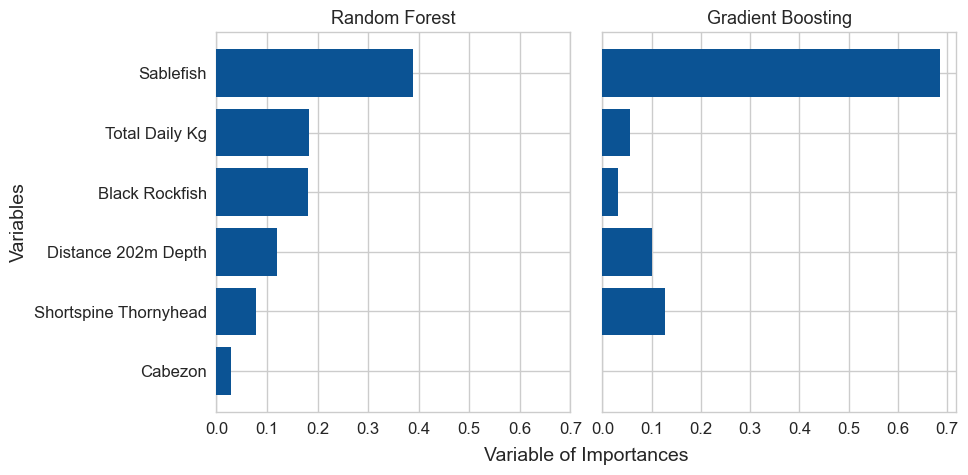

In [112]:
plt.style.use('seaborn-whitegrid')
fig, axes = plt.subplots(figsize=(10,5), ncols=2, facecolor=facecolor, sharey=True) #, sharex=True)

axes[0].barh(index, column0, align='center', color=color_blue, zorder=10)
axes[0].set_title(title0, fontsize=13) #pad=15,
axes[1].barh(index, column1, align='center', color=color_blue, zorder=10)
axes[1].set_title(title1, fontsize=13)
axes[0].set_ylabel("Variables", fontsize=14)
axes[0].set_yticklabels(index,fontsize=12)
axes[0].set_xticks([0.0,0.1,0.2,0.3,0.4,0.5, 0.6,0.7]) 
axes[0].set_xticklabels([0.0,0.1,0.2,0.3,0.4,0.5, 0.6,0.7],fontsize=12)
axes[1].set_xticks([0.0,0.1,0.2,0.3,0.4,0.5, 0.6,0.7]) 
axes[1].set_xticklabels([0.0,0.1,0.2,0.3,0.4,0.5, 0.6,0.7],fontsize=12)
# If you have positive numbers and want to invert the x-axis of the left plot
#axes[0].invert_xaxis() 



# To show data from highest to lowest
plt.gca().invert_yaxis()
fig.text(0.58, 0.1, 'Variable of Importances', ha='center', va='top',fontsize=14)


axes[0].set(yticks=varimport_df.index)
plt.subplots_adjust(wspace=0.09, top=0.93, bottom=0.17, left=0.21, right=0.95)
#plt.subplots_adjust(wspace=0.09, top=0.85, bottom=0.1, left=0.18, right=0.95)


#fig.tight_layout()

#plt.savefig('VariablesImportanceBidirectionalRA5.png', dpi=600)
#filename = 'VariablesImportanceBidirectionalRA3'
#plt.savefig(filename+'.png', facecolor=facecolor)

Text(0.97, 0.5, 'Std Error')

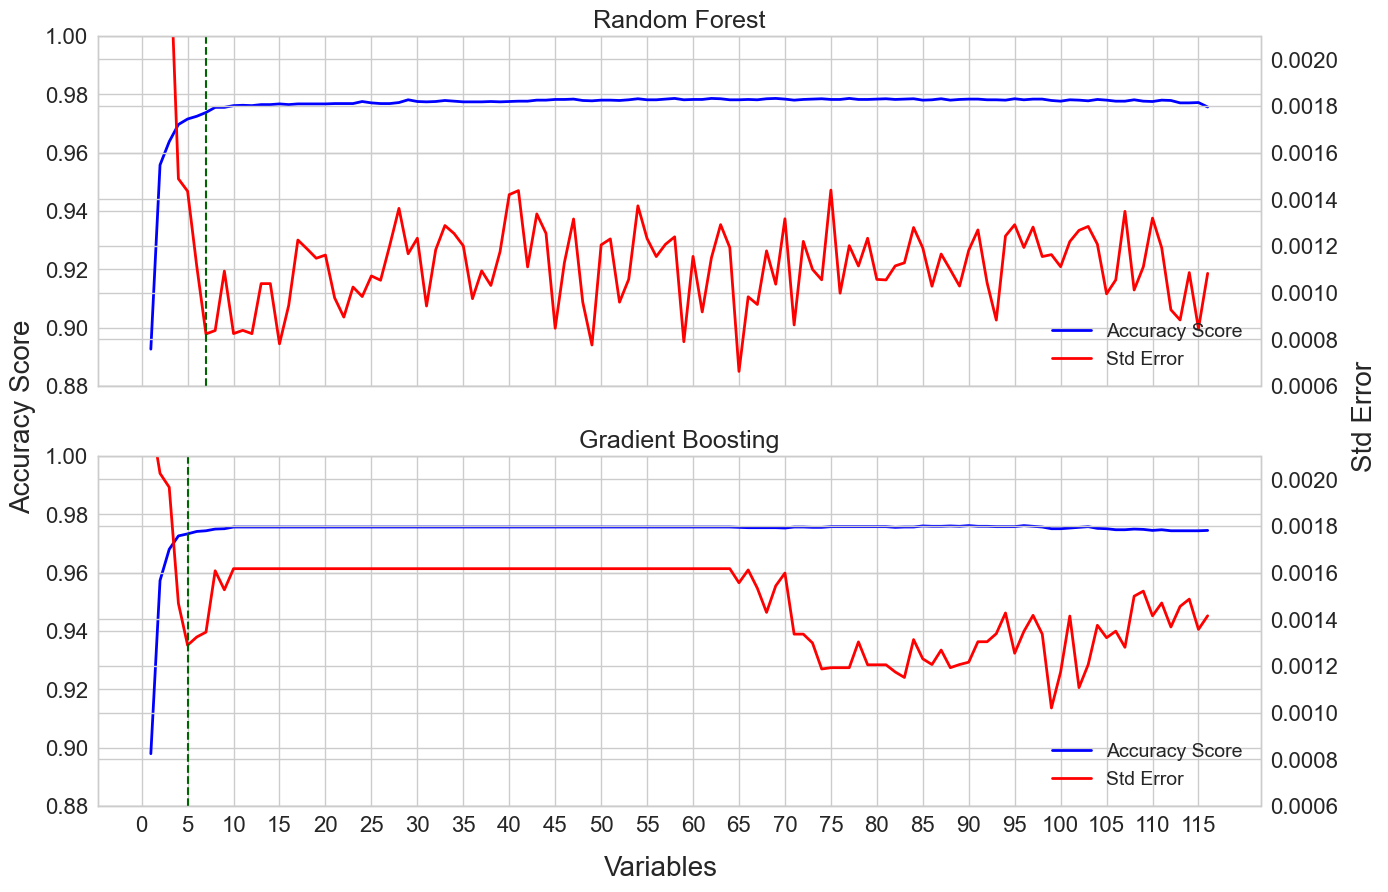

In [111]:
# ploting the sequential forward selection outputs for the two models

plt.style.use('seaborn-whitegrid')
y1 = sfs_rf_df.loc[:,'avg_score']
y2 = sfs_rf_df.loc[:,'std_err']
y3 = sfs_gb_df.loc[:,'avg_score']
y4 = sfs_gb_df.loc[:,'std_err']
x = range(1,117, 1) 


fig, ax = plt.subplots(2, 1, sharex='col', sharey='row', figsize=(15, 10))

# first plot
ax2=ax[0].twinx()
ax[0].set_ylim([0.88, 1.00])
#plt.xticks(np.arange(0, 118, step=4))
plt.ylim([0.0006, 0.0021])
plt.yticks(fontsize=16)

line1, = ax[0].plot(x, y1, 'b-', linewidth=2, label='Accuracy Score')
line2, = plt.plot(x, y2, 'r-', linewidth=2, label='Std Error')
plt.axvline(list(sfs_rf_df_opt["idx_len"]), color = 'darkgreen', linestyle='dashed', linewidth=1.5)


plt.legend(handles=[line1, line2], fontsize=14, loc='lower right')

#second plot
ax2=ax[1].twinx()
ax[1].set_ylim([0.88, 1.00])
plt.ylim([0.0006, 0.0021])
plt.yticks(fontsize=16)

# x-axis ticks
ax[1].set_xticks(np.arange(0, 118, step=5))

line3, = ax[1].plot(x, y3, 'b-', linewidth=2, label='Accuracy Score')
line4, = plt.plot(x, y4, 'r-', linewidth=2, label='Std Error')
plt.axvline(list(sfs_gb_df_opt["idx_len"]), color = 'darkgreen', linestyle='dashed', linewidth=1.5)

ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=16)

# Plot titles
ax[0].set_title('Random Forest',fontsize=18)
ax[1].set_title('Gradient Boosting',fontsize=18)

plt.legend(handles=[line3, line4], fontsize=14, loc='lower right')

#common labels
fig.text(0.5, 0.06, 'Variables', ha='center', va='top',fontsize=20)
fig.text(0.075, 0.5, 'Accuracy Score', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.97, 0.5, 'Std Error', ha='center', va='center', rotation='vertical',fontsize=20)
#plt.subplots_adjust(right=1.0)
#plt.tight_layout()
#plt.savefig('RFGBForwardSelectionFNLRA2.png', dpi=600)


In [101]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [102]:
rfc_clf = RandomForestClassifier()

In [103]:
rf_cols = list(x_train_top_variables.iloc[:,0])

In [104]:
# Selected subset of variables were also used to fit the models whose 
#training data iterated through all but one year, and were tested on the remaining year.

# this was to evaluate the persistence of model efficacy despite inter-annual variability
Randon_Forest_results_df = pd.DataFrame(columns=['Year', 'Accuracy Rate','Error Rate','Precision','Recall','F1-Score'])

for year in range(2019, 2001, -1):
    print('Computing Random Forest Metrics for Year - {}'.format(year))

    # training data is for all years except the current year
    train_subset = wcomp_pivot.loc[wcomp_pivot['Year'] != year]
    X_train, y_train = train_subset[rf_cols], train_subset['Label']

    # testing data is all rows for current year
    test_subset = wcomp_pivot.loc[wcomp_pivot['Year'] == year]
    X_test, y_test = test_subset[rf_cols], test_subset['Label']

    pipe = make_pipeline(MinMaxScaler(), rfc_clf)
    pipe.fit(X_train, y_train)  # apply scaling on training data
    y_pred = pipe.predict(X_test) # getting predictions for test year data

    # computing accuracy metrics
    AR = accuracy_score(y_test, y_pred)
    ER = 1.0 - AR
    P = precision_score(y_test, y_pred)
    R = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)

    # adding accuracy metries to our results dataframe
    Randon_Forest_results_df.loc[-1] = [year, AR, ER, P, R, F1]  # adding a row
    Randon_Forest_results_df.index = Randon_Forest_results_df.index + 1  # shifting index
    Randon_Forest_results_df = Randon_Forest_results_df.sort_index()  # sorting by index

Randon_Forest_results_df.loc['mean'] = Randon_Forest_results_df.mean()
Randon_Forest_results_df.Year = Randon_Forest_results_df.Year.astype(int)

Computing Random Forest Metrics for Year - 2019
Computing Random Forest Metrics for Year - 2018
Computing Random Forest Metrics for Year - 2017
Computing Random Forest Metrics for Year - 2016
Computing Random Forest Metrics for Year - 2015
Computing Random Forest Metrics for Year - 2014
Computing Random Forest Metrics for Year - 2013
Computing Random Forest Metrics for Year - 2012
Computing Random Forest Metrics for Year - 2011
Computing Random Forest Metrics for Year - 2010
Computing Random Forest Metrics for Year - 2009
Computing Random Forest Metrics for Year - 2008
Computing Random Forest Metrics for Year - 2007
Computing Random Forest Metrics for Year - 2006
Computing Random Forest Metrics for Year - 2005
Computing Random Forest Metrics for Year - 2004
Computing Random Forest Metrics for Year - 2003
Computing Random Forest Metrics for Year - 2002


In [105]:
print("\033[1m\n Randon Forest Metrics by Test Year")
Randon_Forest_results_df


 Randon Forest Metrics by Test Year


,Year,Accuracy Rate,Error Rate,Precision,Recall,F1-Score
0,2002,0.962617,0.037383,1.000000,0.961905,0.980583
1,2003,0.942943,0.057057,0.933852,0.991736,0.961924
2,2004,0.953982,0.046018,0.950000,0.956835,0.953405
3,2005,0.964775,0.035225,0.970696,0.963636,0.967153
4,2006,0.950000,0.050000,0.928839,0.957529,0.942966
5,2007,0.961652,0.038348,0.977961,0.951743,0.964674
6,2008,0.962433,0.037567,0.961078,0.975684,0.968326
7,2009,0.968978,0.031022,0.976744,0.967105,0.971901
8,2010,0.968709,0.031291,0.970930,0.982353,0.976608
9,2011,0.976010,0.023990,0.979296,0.981328,0.980311


In [106]:
# gradient boosting best model parameters
gbm_clf = GradientBoostingClassifier()

In [107]:
gb_cols = list(x_train_top_variables_gb.iloc[:,0])

In [108]:
# Selected subset of variables were also used to fit the models whose 
#training data iterated through all but one year, and were tested on the remaining year.

# this was to evaluate the persistence of model efficacy despite inter-annual variability

Gradient_Boosting_results_df = pd.DataFrame(columns=['Year', 'Accuracy Rate','Error Rate','Precision','Recall','F1-Score'])

for year in range(2019, 2001, -1):
    print('Computing Gradient Boosting Metrics for Year - {}'.format(year))

    # training data is for all years except the current year
    train_subset = wcomp_pivot.loc[wcomp_pivot['Year'] != year]
    X_train, y_train = train_subset[gb_cols], train_subset['Label']

    # testing data is all rows for current year
    test_subset = wcomp_pivot.loc[wcomp_pivot['Year'] == year]
    X_test, y_test = test_subset[gb_cols], test_subset['Label']

    pipe = make_pipeline(MinMaxScaler(), gbm_clf)
    pipe.fit(X_train, y_train)  # apply scaling on training data
    y_pred = pipe.predict(X_test) # getting predictions for test year data

    # computing accuracy metrics
    AR = accuracy_score(y_test, y_pred)
    ER = 1.0 - AR
    P = precision_score(y_test, y_pred)
    R = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)

    # adding accuracy metries to our results dataframe
    Gradient_Boosting_results_df.loc[-1] = [year, AR, ER, P, R, F1]  # adding a row
    Gradient_Boosting_results_df.index = Gradient_Boosting_results_df.index + 1  # shifting index
    Gradient_Boosting_results_df = Gradient_Boosting_results_df.sort_index()  # sorting by index

Gradient_Boosting_results_df.loc['mean'] = Gradient_Boosting_results_df.mean()
Gradient_Boosting_results_df.Year = Gradient_Boosting_results_df.Year.astype(int)

Computing Gradient Boosting Metrics for Year - 2019
Computing Gradient Boosting Metrics for Year - 2018
Computing Gradient Boosting Metrics for Year - 2017
Computing Gradient Boosting Metrics for Year - 2016
Computing Gradient Boosting Metrics for Year - 2015
Computing Gradient Boosting Metrics for Year - 2014
Computing Gradient Boosting Metrics for Year - 2013
Computing Gradient Boosting Metrics for Year - 2012
Computing Gradient Boosting Metrics for Year - 2011
Computing Gradient Boosting Metrics for Year - 2010
Computing Gradient Boosting Metrics for Year - 2009
Computing Gradient Boosting Metrics for Year - 2008
Computing Gradient Boosting Metrics for Year - 2007
Computing Gradient Boosting Metrics for Year - 2006
Computing Gradient Boosting Metrics for Year - 2005
Computing Gradient Boosting Metrics for Year - 2004
Computing Gradient Boosting Metrics for Year - 2003
Computing Gradient Boosting Metrics for Year - 2002


In [109]:
print("\033[1m\n Gradient Boosting Metrics by Test Year")
Gradient_Boosting_results_df


 Gradient Boosting Metrics by Test Year


,Year,Accuracy Rate,Error Rate,Precision,Recall,F1-Score
0,2002,0.971963,0.028037,1.000000,0.971429,0.985507
1,2003,0.927928,0.072072,0.916031,0.991736,0.952381
2,2004,0.968142,0.031858,0.974453,0.960432,0.967391
3,2005,0.966732,0.033268,0.977778,0.960000,0.968807
4,2006,0.955000,0.045000,0.932836,0.965251,0.948767
5,2007,0.960177,0.039823,0.977901,0.949062,0.963265
6,2008,0.962433,0.037567,0.961078,0.975684,0.968326
7,2009,0.979927,0.020073,0.983498,0.980263,0.981878
8,2010,0.971317,0.028683,0.971042,0.986275,0.978599
9,2011,0.983586,0.016414,0.989562,0.983402,0.986472


In [110]:
#duration in secs for the process to finish
end = time.time()
end - start

28411.854374170303